In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
from scipy import interpolate
import matplotlib.pyplot as plt
import astropy.constants as const

# Line Broadening

In [2]:
def Lorentz(nus, n, G):
    num = Gamma / (4 * np.pi ** 2)
    deno = (nus - n) ** 2 + (G / (4 * np.pi)) ** 2
    return (num / deno).decompose()

## 1 Natural broadening

The Lorentz Profile centered around a natural frequency $\nu_0$ from an energy level transition is given by

$$\begin{equation}
\varphi_\nu=\frac{\frac{\Gamma}{4\pi^2}}{(\nu-\nu_0)^2+\left(\frac{\Gamma}{4\pi}\right)^2}
\end{equation}$$

where $\Gamma$ is the radiative dampening constant, which can in theory be found by taking the reciprocal of the mean lifetime of the energy levels in question (given by $\Delta E\Delta t\geq\frac{h}{4\pi}$).

Our given values are

In [3]:
lambda0 = 5000 * u.AA
nu0 = const.c / lambda0

delta_t = 10 ** -8 * u.s

This gives us our value for Gamma

In [4]:
Gamma = 1 / delta_t

print(f'Gamma = {Gamma:.0e}')

Gamma = 1e+08 1 / s


Gamma allows us to find the Full Width Half Max (FWHM) of our Lorentz Profile, given by

$$\text{FWHM}=\frac{\Gamma}{2\pi}$$

meaning our expected FWHM would be

In [5]:
FWHM = Gamma / (2 * np.pi)

print(f'FWHM = {(FWHM * const.c / nu0 ** 2).to(u.AA):.2e}')

FWHM = 1.33e-04 Angstrom


Now let's define our range of frequencies we will use as our domain:

In [6]:
delta_nu = 5 * 10 ** 7 * u.Hz

nus = np.linspace(nu0 - delta_nu, nu0 + delta_nu, 1000).decompose()

Plotting our function we get

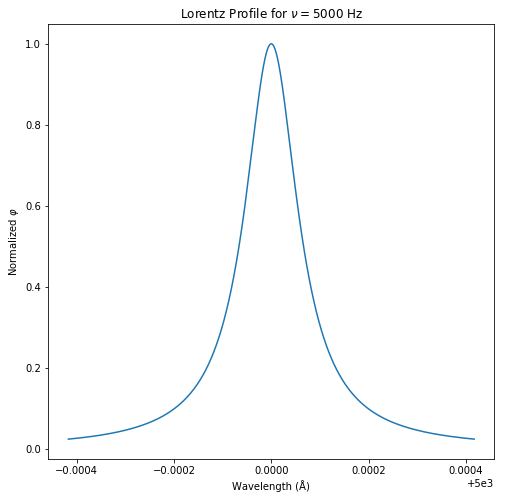

In [7]:
phi = Lorentz(nus, n=nu0, G=Gamma)
lambdasL = (const.c / nus).to(u.AA)
plt.figure(figsize=(8,8))
plt.plot(lambdasL, phi / np.max(phi))
plt.title(r'Lorentz Profile for $\nu=5000$ Hz')
plt.xlabel('Wavelength (Å)')
plt.ylabel(r'Normalized $\varphi$')
plt.show()

which allows us to see

In [8]:
half = nus[np.argwhere(phi > np.max(phi) / 2)]
FWHM = half[-1][0] - half[0][0]

print(f'FWHM = {(FWHM * const.c / nu0 ** 2).to(u.AA):.2e}')

FWHM = 1.33e-04 Angstrom


which agrees with our calculated value for the FWHM.

## 2 Doppler broadening

We start with our given initial conditions

In [9]:
T = 10000 * u.K
lambda0 = 4481 * u.AA
m = 24.305 * u.u

Let us first calculate $V_{th}$, the most likely velocity the particles will have at a given temperature $T$, using

$$
V_{th}=\sqrt{\frac{2k_BT}{m}}
$$

giving us

In [10]:
Vth = np.sqrt(2 * const.k_B * T / m).decompose()
print(f'Vth = {Vth:.2f}')

Vth = 2615.68 m / s


Next we calculate $\Delta\lambda_D$ by using

$$\Delta\nu_D=\frac{V_{th}\nu_0}{c}$$

and

$$\Delta\lambda=\Delta\nu \frac{{\lambda_0}^2}{c}$$

giving us

In [11]:
nu0 = const.c / lambda0

deltanu = Vth * nu0 / const.c
deltalam = deltanu * lambda0 ** 2 / const.c

print(f'Δ𝜆𝐷 = {deltalam:.4f}')

Δ𝜆𝐷 = 0.0391 Angstrom


Plotting the corresponding gaussian profile using

$$
\exp{\left(-\frac{(\lambda-\lambda_0)^2}{\Delta\lambda_D^2}\right)}
$$

giving us

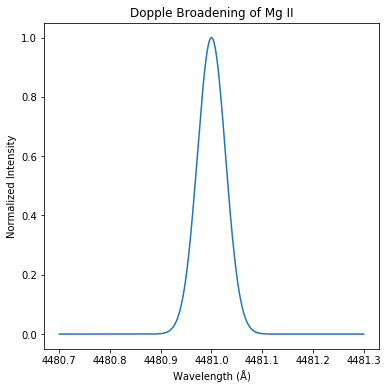

In [12]:
domrange = 0.3 * u.AA
lambdas = np.linspace(lambda0 - domrange, lambda0 + domrange, 10000)

gauss = np.exp(- (lambdas - lambda0) ** 2 / deltalam ** 2).decompose()

plt.figure(figsize=(6,6))
plt.plot(lambdas, gauss)
plt.title('Dopple Broadening of Mg II')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Normalized Intensity')
plt.show()

Next we calculate the value for $\lambda=\lambda_0+\Delta\lambda_D$, giving us

In [13]:
lam = lambda0 + deltalam
gaulam = np.exp(- (lam - lambda0) ** 2 / deltalam ** 2).decompose()

print(f'I(𝜆) = {gaulam:.4f}')

I(𝜆) = 0.3679


which is equivalent to $e^{-1}$.

We are now ready to compare doppler broadening to the Lorentz profile. First, let us re-calculate the Lorentz profile for the wavelength $4481\,Å$

In [14]:
domrange = 1 * u.AA
lambdas = np.linspace(lambda0 - domrange, lambda0 + domrange, 10000)
nus = const.c / lambdas
phi = Lorentz(nus, n=nu0, G=Gamma)

Plotting our figure we get

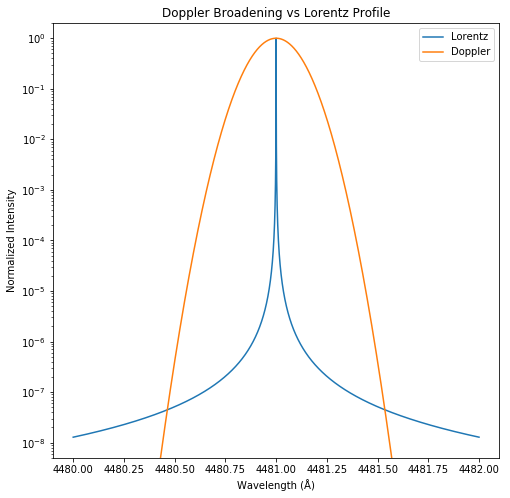

In [15]:
plt.figure(figsize=(8,8))
plt.plot(lambdas, phi / np.max(phi), label='Lorentz')
plt.plot(lambdas, gauss, label='Doppler')
plt.yscale('log')
plt.title(r'Doppler Broadening vs Lorentz Profile')
plt.xlabel('Wavelength (Å)')
plt.ylabel(r'Normalized Intensity')
plt.ylim(5 * 10 ** -9, 2)
plt.legend(loc='best')
plt.show()

Thus the interval where the Doppler profile contributes more than the Lorentz profile is

In [16]:
half = lambdas[gauss > phi / np.max(phi)]

print(f'Doppler > Lorentz = ({(half[0]).to(u.AA).value:.3f}, '
      f'{(half[-1]).to(u.AA).value:.3f}) Å')

Doppler > Lorentz = (4480.464, 4481.536) Å


## 3 Rotation

Our basic stellar parameters are

In [17]:
stars = {'O5': {'mass': 40 * u.M_sun, 'radius': 17.8 * u.R_sun},
         'B5': {'mass': 6.4 * u.M_sun, 'radius': 3.8 * u.R_sun},
         'A5': {'mass': 2.1 * u.M_sun, 'radius': 1.7 * u.R_sun},
         'F5': {'mass': 1.3 * u.M_sun, 'radius': 1.2 * u.R_sun},
         'G5': {'mass': 0.9 * u.M_sun, 'radius': 0.9 * u.R_sun}}

We can find $v_\text{esc}$ using

$$
v_\text{esc}=\sqrt{\frac{2GM}{r}}
$$

giving us

In [18]:
for star in stars:
    stars[star]['v_esc'] = np.sqrt(2 * stars[star]['mass'] * const.G 
                          / stars[star]['radius']).to(u.km / u.s).round(2)

df = pd.DataFrame(stars).T

df

,mass,radius,v_esc
O5,40.0 solMass,17.8 solRad,925.93 km / s
B5,6.4 solMass,3.8 solRad,801.6 km / s
A5,2.1 solMass,1.7 solRad,686.51 km / s
F5,1.3 solMass,1.2 solRad,642.9 km / s
G5,0.9 solMass,0.9 solRad,617.67 km / s


As we can see, the hotter the spectral class, the greater the escape velocity.

Now we reason that the greatest possible rotational velocity $v_\text{rot}$ for a star is its escape velocity; any greater and the star would fly apart. Thus, the greatest possible rotational broadening would be

$$\Delta\lambda_{max}=\frac{2\lambda v_{esc}}{c}$$

Which, for a line at 5000Å, would give us

In [19]:
for star in stars:
    stars[star]['Δ𝜆_max'] = (2 * 5000 * u.AA * stars[star]['v_esc']
                                  / const.c).to(u.AA).round(2)

df = pd.DataFrame(stars).T

df

,mass,radius,v_esc,Δ𝜆_max
O5,40.0 solMass,17.8 solRad,925.93 km / s,30.89 Angstrom
B5,6.4 solMass,3.8 solRad,801.6 km / s,26.74 Angstrom
A5,2.1 solMass,1.7 solRad,686.51 km / s,22.9 Angstrom
F5,1.3 solMass,1.2 solRad,642.9 km / s,21.44 Angstrom
G5,0.9 solMass,0.9 solRad,617.67 km / s,20.6 Angstrom
